# QNN with PennyLane

<!--
Source:
https://www.qmunity.tech/tutorials/quantum-neural-networks
https://medium.com/xanaduai/training-quantum-neural-networks-with-pennylane-pytorch-and-tensorflow-c669108118cc
https://github.com/MonitSharma/Learn-Quantum-Machine-Learning
-->

In [30]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Creating the data

## sine function
X = np.linspace(0, 3, 100)
y = np.sin(X)
X = np.reshape(X, (-1, 1))

(<Figure size 700x200 with 1 Axes>, <Axes: >)

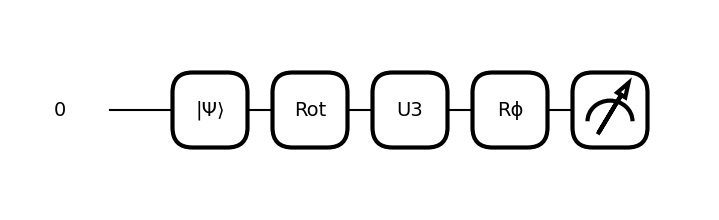

In [49]:
qubits = 1
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(theta, X):
    qml.AmplitudeEmbedding(X, wires=0, pad_with=1e-5, normalize=True)
    qml.Rot(*theta[:3], wires=0)
    qml.U3(*theta[4:7], wires=0)
    qml.PhaseShift(theta[3], wires=0)
    # Bias
    # qml.Displacement(theta[3], 0.0, wires=0)

    # nonlinear transformation
    # qml.Kerr(theta[3], wires=0)
    
    return qml.expval(qml.Z(0))

theta = 0.05 * np.random.randn(7)
qml.draw_mpl(circuit)(theta, X[0])

In [50]:
def square_loss(label, pred):
    return (label-pred)**2

optim = qml.AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

def cost(theta, xi, yi):
    preds = circuit(theta, xi)
    return square_loss(yi, preds)

theta_init = 0.05 * np.random.randn(7, requires_grad=True)
theta = theta_init

for i in range(100):
    costs = []
    for j in range(len(X)):
        theta, cost_ = optim.step_and_cost(cost, theta, xi=X[j], yi=y[j])
        costs.append(cost_)
    if i%5 == 0 or i==99:
        print(f"Iter: {i:5d} | Cost: {cost_.mean():0.7f} ")

C:\Users\LENOVO\miniconda3\envs\_env_qml_\Lib\site-packages\autograd\numpy\numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Iter:     0 | Cost: 0.2972261 
Iter:     5 | Cost: 0.4463038 
Iter:    10 | Cost: 0.4432223 
Iter:    15 | Cost: 0.4406660 
Iter:    20 | Cost: 0.4410697 
Iter:    25 | Cost: 0.4288457 
Iter:    30 | Cost: 0.3736190 
Iter:    35 | Cost: 0.3721725 
Iter:    40 | Cost: 0.3583173 
Iter:    45 | Cost: 0.3696164 
Iter:    50 | Cost: 0.3840033 
Iter:    55 | Cost: 0.3833481 
Iter:    60 | Cost: 0.3838981 
Iter:    65 | Cost: 0.3838318 
Iter:    70 | Cost: 0.3837240 
Iter:    75 | Cost: 0.3836677 
Iter:    80 | Cost: 0.3836383 
Iter:    85 | Cost: 0.3836211 
Iter:    90 | Cost: 0.3836104 
Iter:    95 | Cost: 0.3836032 
Iter:    99 | Cost: 0.3835990 


In [47]:
preds = np.array([circuit(theta, xi) for xi in X])

plt.figure()
plt.scatter(X, y)
plt.scatter(X, preds, color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

TypeError: U3.__init__() missing 3 required positional arguments: 'theta', 'phi', and 'delta'

In [52]:
qml.version()

'0.35.1'

# pennylane demo

In [1]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Generation of Training Graphs

In [2]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

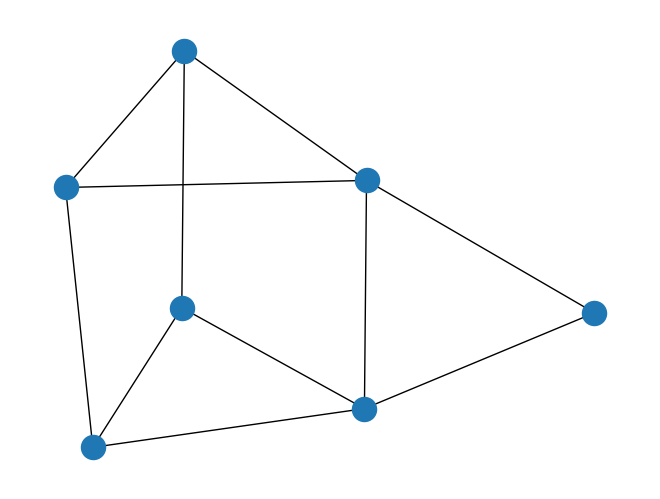

In [3]:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [4]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))

    # Define the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, diff_method="backprop", interface="tf")

        return cost(params)

    return hamiltonian

In [5]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))

tf.Tensor(-3.1932679572555784, shape=(), dtype=float64)


## Recurrent Neural Network: LSTM

In [6]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

In [7]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

In [8]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]


def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

In [9]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)

    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

In [ ]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/20 - Loss: -1.6566956043243408
 > Graph 6/20 - Loss: -1.429755449295044
 > Graph 11/20 - Loss: -1.3686835765838623
 > Graph 16/20 - Loss: -1.2627521753311157
 >> Mean Loss during epoch: -1.7317298233509064
Epoch 2
 > Graph 1/20 - Loss: -2.117368698120117
